In [1]:
try:
    import open_clip
    from optim_utils import * 
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import open_clip
    from optim_utils import * 

import torch
import mediapy as media
import argparse

## Load Arguments

In [2]:
args = argparse.Namespace()
args.__dict__.update(read_json("sample_config.json"))

args.prompt_len = 8

args

Namespace(prompt_len=8, iter=3000, lr=0.1, weight_decay=0.1, prompt_bs=1, loss_weight=1.0, print_step=100, batch_size=2, clip_model='ViT-H-14', clip_pretrain='laion2b_s32b_b79k')

## Load Clip Model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, device=device)

## Load Diffusion Model

In [4]:
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
    )
pipe = pipe.to(device)

image_length = 512

Error caught was: No module named 'triton'
Fetching 12 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1337.33it/s]


## Enter Target Prompt

In [5]:
target_prompts = [
        "realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field",
       ]
print(target_prompts)

['realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field']


## Optimize Prompt

In [6]:
learned_prompt = optimize_prompt(model, preprocess, args, device, target_prompts=target_prompts)

step: 0, lr: 0.1, cosim: -0.058, text: trusted jancolesentering hammers cky anglo along 
step: 100, lr: 0.1, cosim: 0.545, text: car underwater wreck rigged patricks blockchain surrealism seascape 
step: 200, lr: 0.1, cosim: 0.583, text: car underwater leonardo texture illustration wrecks scifi scene 
step: 300, lr: 0.1, cosim: 0.672, text: car sofia mattenomanrender scifi scifi scene 
step: 400, lr: 0.1, cosim: 0.583, text: cars underwater renderexterior render logistics logistics landscape 
step: 500, lr: 0.1, cosim: 0.688, text: car vivirenderexterior panorama surrealism cyberpunk panorama 
step: 600, lr: 0.1, cosim: 0.705, text: car shinexterior cgi render rundown futuristic studio 
step: 700, lr: 0.1, cosim: 0.763, text: car unreal �️ cgi rendering cyberpunk futuristic factory 
step: 800, lr: 0.1, cosim: 0.792, text: car realialec render cgi scifi scifi factory 
step: 900, lr: 0.1, cosim: 0.652, text: car nikoltopaz workflow panorama cyberpunk scifi workshop 
step: 1000, lr: 0.1, 

## Generate with Stable Diffusion Model

Token indices sequence length is longer than the specified maximum sequence length for this model (100 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['incev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field']
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.93it/s]


original prompt: realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field



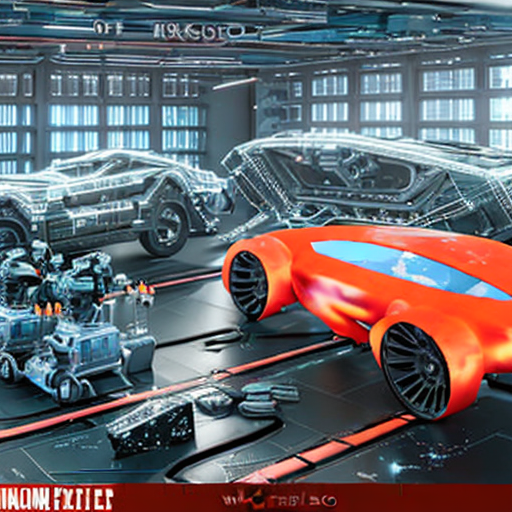
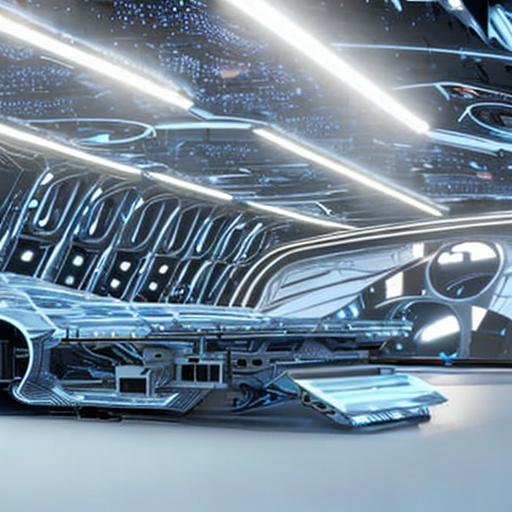
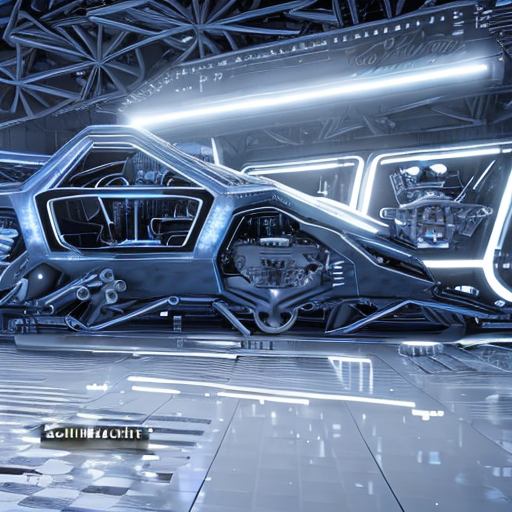
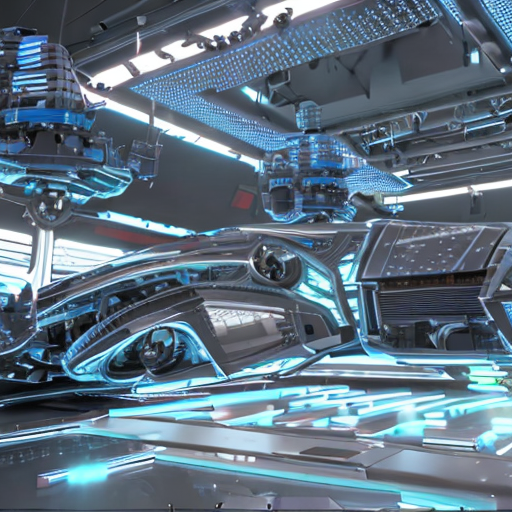

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.57it/s]


learned prompt: render cgi digital pushawardsscifi car car factory 



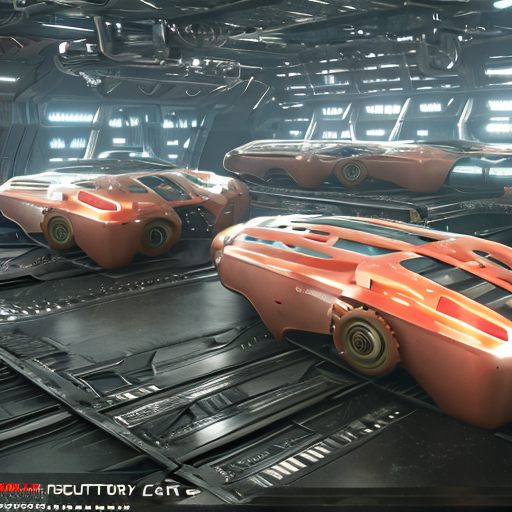
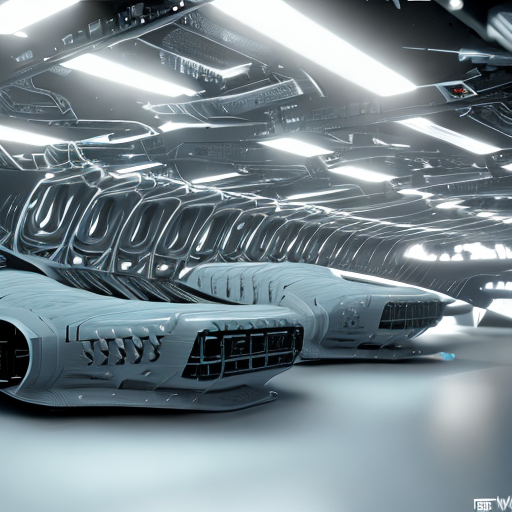
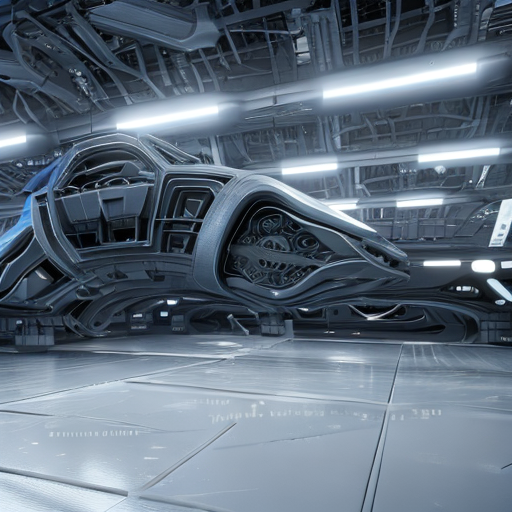
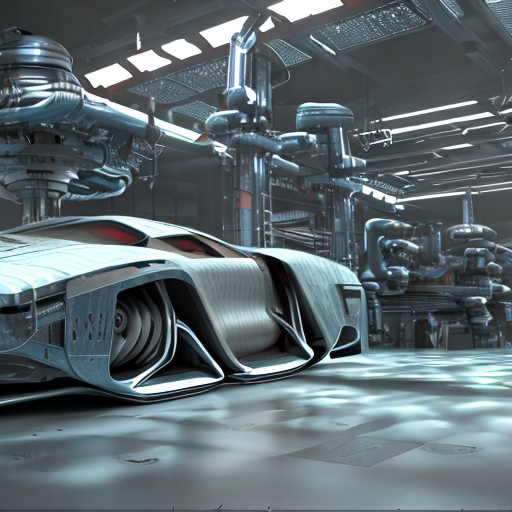

In [7]:
num_images = 4
guidance_scale = 9
num_inference_steps = 25
seed = 0

set_random_seed(seed)
images = pipe(
    target_prompts[0],
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    ).images
print(f"original prompt: {target_prompts[0]}")
media.show_images(images)

set_random_seed(seed)
images = pipe(
    learned_prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    ).images

print(f"learned prompt: {learned_prompt}")
media.show_images(images)